In [1]:
# !pip install --upgrade pip
# !pip install -r requirements.txt

# Dataset downloading

In [14]:
import kagglehub
import shutil
import os

In [15]:
cache_path = kagglehub.dataset_download("carlolepelaars/camvid")

In [16]:
target_path = "CamVid"

In [17]:
if not os.path.exists(target_path):
    shutil.copytree(cache_path, target_path)

# Training

In [22]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

/Users/uzbtrust/Desktop/road detection/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [24]:
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 10
ROAD_COLOR = [128, 64, 128]

In [30]:
def load_and_preprocess(img_path, mask_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    binary_mask = np.all(mask == ROAD_COLOR, axis=-1).astype(float)
    binary_mask = np.expand_dims(binary_mask, axis=-1)
    
    return img, binary_mask

In [32]:
train_imgs, train_masks = [], []
img_names = sorted(os.listdir('CamVid/train'))[:300] 

for name in img_names:
    img_p = os.path.join('CamVid/train', name)
    mask_p = os.path.join('CamVid/train_labels', name.replace('.png', '_L.png'))
    if os.path.exists(mask_p):
        img, msk = load_and_preprocess(img_p, mask_p)
        train_imgs.append(img)
        train_masks.append(msk)

X = np.array(train_imgs)
y = np.array(train_masks)

In [33]:
def build_deep_unet():
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    
    u1 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    
    u2 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    return models.Model(inputs, outputs)

In [36]:
model = build_deep_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(f"Number of epochs: {EPOCHS}")
history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE)

Number of epochs: 10
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7318 - loss: 0.4761
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8636 - loss: 0.3290
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8998 - loss: 0.2398
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9044 - loss: 0.2268
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9198 - loss: 0.1914
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9263 - loss: 0.1731
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9318 - loss: 0.1620
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9320 - loss: 0.1611
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9356 - loss: 0.1543
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9408 - loss: 0.1422


# Getting results

In [37]:
import random

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


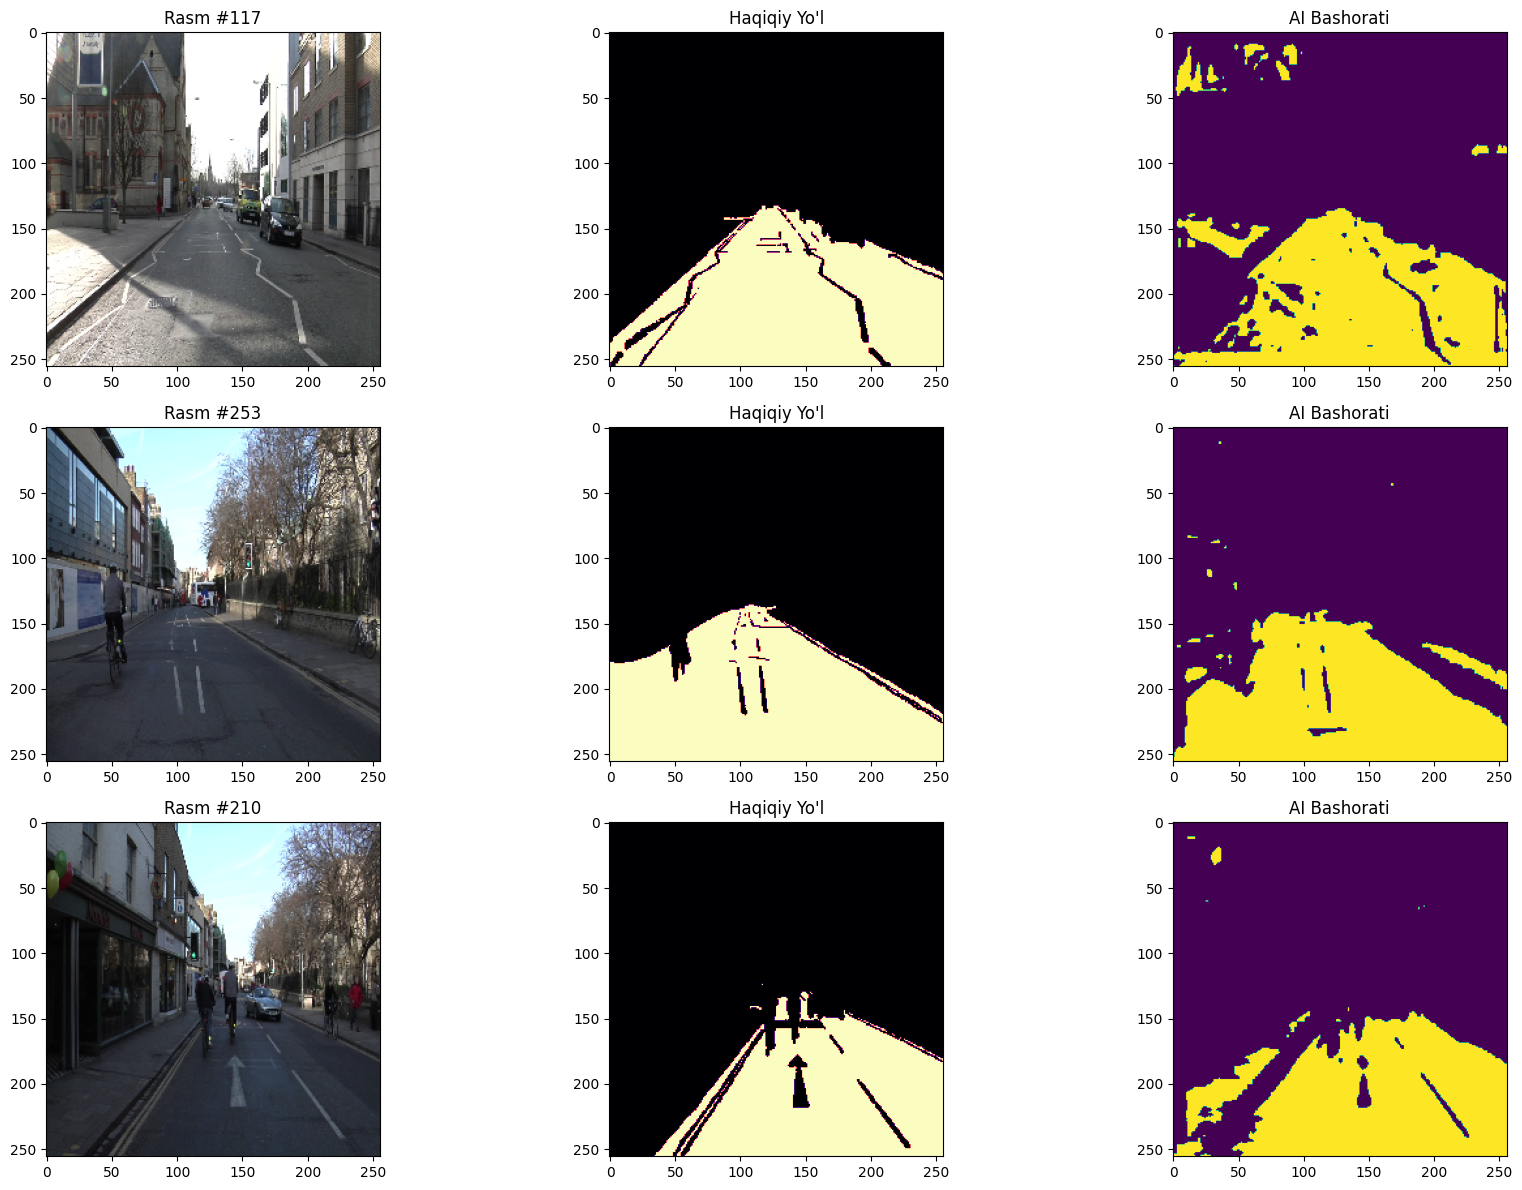

In [38]:
plt.figure(figsize=(18, 12))
for i in range(3):
    idx = random.randint(0, len(X)-1)
    test_img = np.expand_dims(X[idx], axis=0)
    pred_mask = model.predict(test_img)

    # Original rasm
    plt.subplot(3, 3, i*3 + 1); plt.imshow(X[idx]); plt.title(f"Rasm #{idx}")
    # Haqiqiy maska
    plt.subplot(3, 3, i*3 + 2); plt.imshow(y[idx].squeeze(), cmap='magma'); plt.title("Haqiqiy Yo'l")
    # AI bashorati (Tesla Style)
    plt.subplot(3, 3, i*3 + 3); plt.imshow(pred_mask[0].squeeze() > 0.5, cmap='viridis'); plt.title("AI Bashorati")

plt.tight_layout()
plt.show()

In [40]:
model.save('tesla_road_model.keras')